In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from collections import defaultdict
from tqdm import tqdm_notebook

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

# from matplotlib import rc
# rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
# rc('figure', **{'dpi': 300})

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Реализуем крестики-нолики

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    # def getState(self):
    #     return (self.getHash(), ''.join([str(self.int_from_action(x)) for x in self.getEmptySpaces()]), self.curTurn)
    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return (int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        action = self.action_from_int(action)
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    '''Рисуем доску с оценками из стратегии pi'''
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i, a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % (pi.Q[s][i]), fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
#             else:
#                 ax.text( a[1] , a[0] , "???", fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
    cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, random=False, verbose=True, fontq=20, fontx=60):
    '''Делаем ход, рисуем доску'''
    plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                print(i, a, pi.Q[s][i])
        else:
            print("Стратегия не знает, что делать...")
    if random:
        new_action = env.int_from_action(actions[np.random.randint(len(actions))])
    else:
        new_action = pi.getAction(s, eps=0)
    return new_action

In [5]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, verbose=True, fontq=20, fontx=60):
    '''Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры'''
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        print(f"Current action:{a}")
        observation, reward, done, info = env.step(a)
        if reward == 1:
            print("Крестики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            print("Нолики выиграли!")
            plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)

In [6]:
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=20)

# Q learning

In [7]:
class Policy(object):
  def __init__(self, Q, N_ROWS, N_COLS):
    self.Q = Q
    self.n_rows = N_ROWS
    self.n_cols = N_COLS

  def getAction(self, s, eps):
    return (np.argmax(self.Q[s])
              if np.random.rand() > eps 
              else np.random.randint(self.n_rows * self.n_cols))
  
  def updateQ(self, s, a, s_prime=None, reward=0, alpha=0.05, gamma=0.9, done=False):
    if not done and not s_prime:
      raise Exception("Done is False but s_prime is not provided")

    if not s_prime:
        self.Q[s][a] = reward
        # self.Q[s][a] = self.Q[s][a] + alpha * (reward - self.Q[s][a])
    else:
      self.Q[s][a] = self.Q[s][a] + alpha * (reward + gamma * np.max(self.Q[s_prime]) - self.Q[s][a])

In [8]:
def calc_real_reward(cur_turn, me, reward):
  if (cur_turn == me) and (reward == -10):
    real_reward = -10
  if (cur_turn != me) and (reward == -10):
    raise Exception("Opponent made bad choose")
  if (reward != -10):
    real_reward = me * reward
  return real_reward

In [9]:
def Q_learning_episode(env, pi1, pi2, alpha=0.05, epsilon=0.0, gamma=0.9):
    env.reset()
    cur_turn = 1
    s = env.getState()[0]
    a_crosses_prev = None
    a_naughts_prev = None
    s_naughts_prev = None
    s_crosses_prev = None
    done = False
    while not done:
      if cur_turn == 1:
        a = pi1.getAction(s, epsilon)
        observation, reward, done, info = env.step(a)
        cur_turn_prime = observation[-1]
        if done:
            pi1.updateQ(s, a, reward=reward, alpha=alpha, gamma=gamma, done=done)
# If we chose the wrong action, we should not update the other side's state, so break            
            if reward == -10:
              break
# Now it becomes previous state for crosses
        s_crosses_prev = s
        a_crosses_prev = a
        s_prime = observation[0]

        if s_naughts_prev:
# If we won, we should give negative reward to the opponent
           pi2.updateQ(s_naughts_prev, a_naughts_prev, s_prime, reward=-reward, alpha=alpha, gamma=gamma, done=done)

      else:
        a = pi2.getAction(s, epsilon)
        observation, reward, done, info = env.step(a)
        cur_turn_prime = observation[-1]
        if done:
# If we won, the we should give positive reward
            if reward == -1:
              pi2.updateQ(s, a, reward=-reward, alpha=alpha, gamma=gamma, done=done)
# Else happens when reward is -10
            else:
              pi2.updateQ(s, a, reward=reward, alpha=alpha, gamma=gamma, done=done)
# If we chose the wrong action, we should not update the other side's state, so break  
              break              
# Now it becomes previous state for naughts
        s_naughts_prev = s
        a_naughts_prev = a
        s_prime = observation[0]
# If we won, we should give negative reward to the opponent. In this part the negative one is the reward        
        pi1.updateQ(s_crosses_prev, a_crosses_prev, s_prime, reward=reward, alpha=alpha, gamma=gamma, done=done)

      s = s_prime
      cur_turn = cur_turn_prime

In [10]:
def test_strategy(env, pi, me=None):
  env.reset()
  s = env.getState()[0]
  if me:
    a = pi.getAction(s, eps=0)
  else:
    a = pi.getAction(s, eps=1)

  while(1):
    observations, reward, done, _ = env.step(a)
    s = observations[0]
    cur_turn = observations[-1]
# Calculate real reward
    if done:
      real_reward = calc_real_reward(cur_turn, me, reward)
      return real_reward
# Choose action    
    if cur_turn == me:
      a = pi.getAction(s, eps=0)
    else:
      available_actions = [env.int_from_action(x) for x in env.getEmptySpaces()]
      a = np.random.choice(available_actions)

## Train

In [11]:
def train(env, pi1=None, pi2=None, total_episodes=100000, total_episodes_test=10000, 
          episodes_estimation_interval=10000, epsilon=0.1, alpha=0.05, gamma=0.9):
  if not pi1:
    Q1 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
    pi1 = Policy(Q1, env.n_rows, env.n_cols)
  if not pi2:
    Q2 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
    pi2 = Policy(Q2, env.n_rows, env.n_cols)
  
  Q_wins = []
  Q_loses = []
  Q_draws = []
  Q_crashes = []
  for i in tqdm_notebook(range(total_episodes)):
      if i % episodes_estimation_interval == 0:
        wins = 0
        loses = 0
        draws = 0
        crashes = 0
        for _ in range(total_episodes_test):
          me = np.random.choice([-1, 1])
          if me == 1:
            reward = test_strategy(env, pi1, me)
          else:
            reward = test_strategy(env, pi2, me)
          if reward == -1:
            loses += 1
          elif reward == 1:
            wins += 1
          elif reward == 0:
            draws += 1
          else:
            crashes += 1
        Q_wins.append(wins / total_episodes_test)
        Q_loses.append(loses / total_episodes_test)
        Q_draws.append(draws / total_episodes_test)
        Q_crashes.append(crashes / total_episodes_test)
        print(f"Wins:{Q_wins[-1]}, Loses:{Q_loses[-1]}, Draws:{Q_draws[-1]}, Crashes:{Q_crashes[-1]}")
      Q_learning_episode(env, pi1, pi2, epsilon=epsilon, alpha=alpha, gamma=gamma)
      
      
  wins = 0
  loses = 0
  draws = 0
  crashes = 0
  for _ in range(total_episodes_test):
    me = np.random.choice([-1, 1])
    if me == 1:
      reward = test_strategy(env, pi1, me)
    else:
      reward = test_strategy(env, pi2, me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1
  Q_wins.append(wins / total_episodes_test)
  Q_loses.append(loses / total_episodes_test)
  Q_draws.append(draws / total_episodes_test)
  Q_crashes.append(crashes / total_episodes_test)
  print(f"Wins:{Q_wins[-1]}, Loses:{Q_loses[-1]}, Draws:{Q_draws[-1]}, Crashes:{Q_crashes[-1]}")
  return pi1, pi2, Q_wins, Q_loses, Q_draws, Q_crashes

## 3x3

In [ ]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
pi1, pi2, Q_wins, Q_loses, Q_draws, Q_crashes = train(env, 
                                     total_episodes=300000,
                                     total_episodes_test=10000,
                                     episodes_estimation_interval=30000,
                                     epsilon=0.3,
                                     alpha=0.01,
                                     gamma=1,
                                     )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Wins:0.0979, Loses:0.1482, Draws:0.0125, Crashes:0.7414
Wins:0.4831, Loses:0.1679, Draws:0.0934, Crashes:0.2556
Wins:0.6725, Loses:0.1319, Draws:0.0656, Crashes:0.13
Wins:0.8357, Loses:0.0659, Draws:0.0733, Crashes:0.0251
Wins:0.8837, Loses:0.0284, Draws:0.0669, Crashes:0.021
Wins:0.9039, Loses:0.0224, Draws:0.0618, Crashes:0.0119
Wins:0.7399, Loses:0.18, Draws:0.0576, Crashes:0.0225
Wins:0.9218, Loses:0.0232, Draws:0.052, Crashes:0.003
Wins:0.926, Loses:0.0164, Draws:0.0576, Crashes:0.0
Wins:0.9426, Loses:0.0104, Draws:0.047, Crashes:0.0

Wins:0.927, Loses:0.0137, Draws:0.0579, Crashes:0.0014


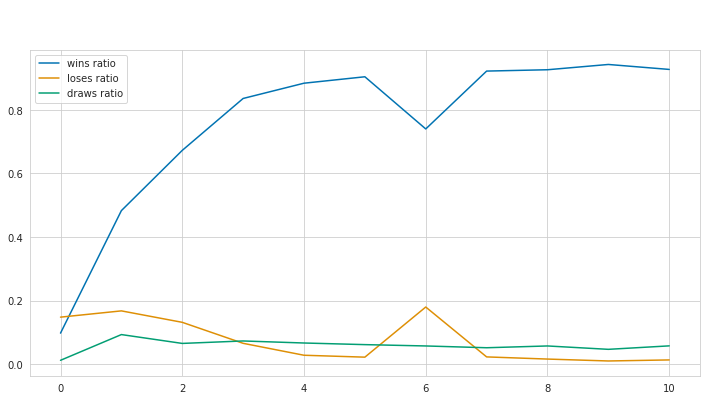

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(list(range(len(Q_wins))), Q_wins, label="wins ratio")
plt.plot(list(range(len(Q_loses))), Q_loses, label="loses ratio")
plt.plot(list(range(len(Q_draws))), Q_draws, label="draws ratio")
plt.suptitle("Win/loses/draws ratios by steps", color='white')
plt.legend()

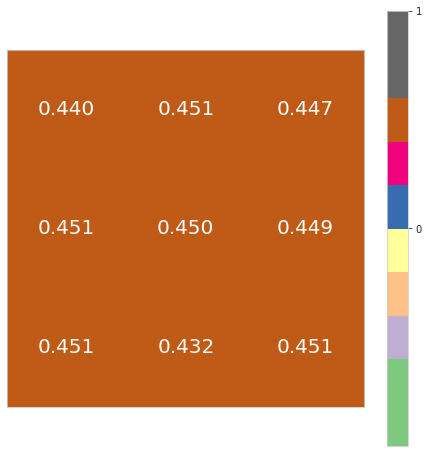

0 [0 0] 0.43950272450145933
1 [0 1] 0.45072411580379135
2 [0 2] 0.4473683599144372
3 [1 0] 0.45111031882597846
4 [1 1] 0.45007837828423447
5 [1 2] 0.449072222949019
6 [2 0] 0.45121739793221965
7 [2 1] 0.43167518602093924
8 [2 2] 0.4508192816057513
Current action:6


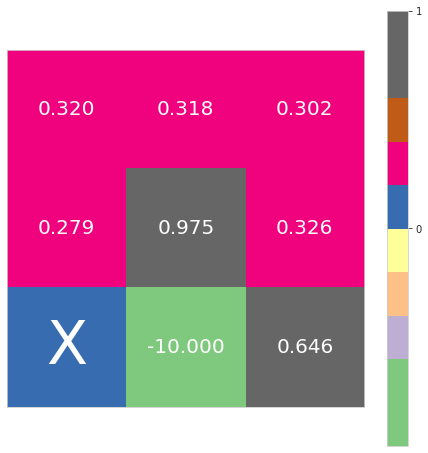

0 [0 0] 0.319560221953466
1 [0 1] 0.3184512662894583
2 [0 2] 0.30225590969897553
3 [1 0] 0.2786081798349499
4 [1 1] 0.9749831204308987
5 [1 2] 0.32627563652023517
6 [2 1] -10.0
7 [2 2] 0.6463510810859818
Current action:8


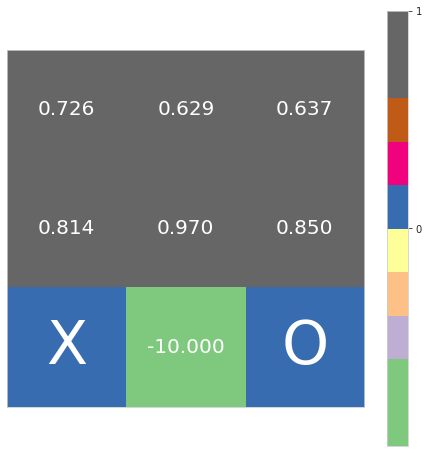

0 [0 0] 0.7261172263970274
1 [0 1] 0.6291780314742166
2 [0 2] 0.6366621120100222
3 [1 0] 0.8144006585658903
4 [1 1] 0.9697397452478856
5 [1 2] 0.8504081553405964
6 [2 1] -10.0
Current action:4


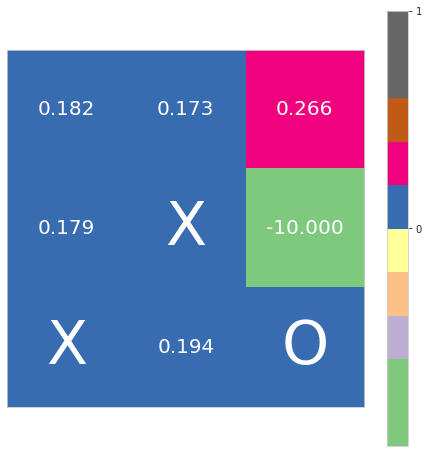

0 [0 0] 0.18218500557621425
1 [0 1] 0.17339569968050547
2 [0 2] 0.265716624738491
3 [1 0] 0.17880813046695743
4 [1 2] -10.0
5 [2 1] 0.19395826520185944
Current action:7


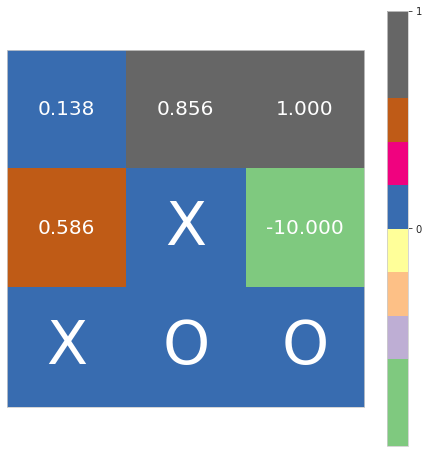

0 [0 0] 0.1376859353721228
1 [0 1] 0.8558672526718792
2 [0 2] 1.0
3 [1 0] 0.5861906285625376
4 [1 2] -10.0
Current action:2
Крестики выиграли!


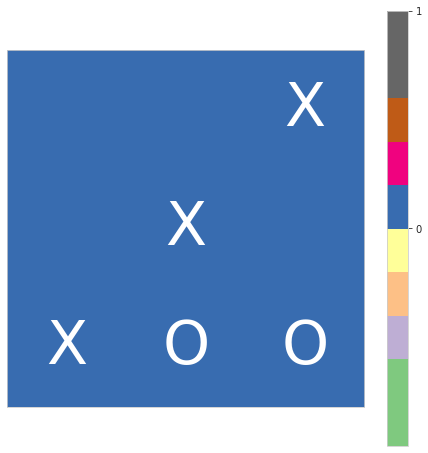

In [ ]:
plot_test_game(env, pi1=pi1, pi2=pi2)

## 4x4

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4

In [ ]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
pi1, pi2, Q_wins, Q_loses, Q_draws, Q_crashes = train(env, 
                                     total_episodes=1000000,
                                     total_episodes_test=10000,
                                     episodes_estimation_interval=100000,
                                     epsilon=0.3,
                                     alpha=0.01,
                                     gamma=1,
                                     )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Wins:0.0092, Loses:0.0131, Draws:0.0006, Crashes:0.9771
Wins:0.0199, Loses:0.0207, Draws:0.0012, Crashes:0.9582
Wins:0.0189, Loses:0.0264, Draws:0.0017, Crashes:0.953
Wins:0.0291, Loses:0.0345, Draws:0.0011, Crashes:0.9353
Wins:0.0302, Loses:0.0273, Draws:0.0013, Crashes:0.9412
Wins:0.0215, Loses:0.0315, Draws:0.0012, Crashes:0.9458
Wins:0.0269, Loses:0.028, Draws:0.0017, Crashes:0.9434
Wins:0.0309, Loses:0.0306, Draws:0.0019, Crashes:0.9366
Wins:0.0355, Loses:0.0349, Draws:0.0012, Crashes:0.9284
Wins:0.0239, Loses:0.0327, Draws:0.0014, Crashes:0.942

Wins:0.0217, Loses:0.0426, Draws:0.0019, Crashes:0.9338


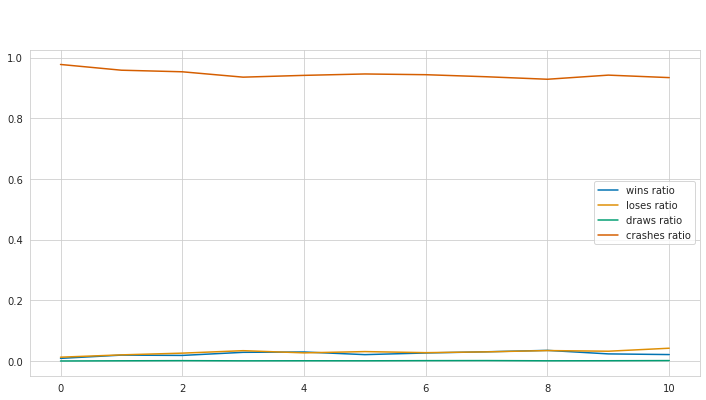

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(list(range(len(Q_wins))), Q_wins, label="wins ratio")
plt.plot(list(range(len(Q_loses))), Q_loses, label="loses ratio")
plt.plot(list(range(len(Q_draws))), Q_draws, label="draws ratio")
plt.plot(list(range(len(Q_crashes))), Q_crashes, label="crashes ratio")
plt.suptitle("Win/loses/draws ratios by steps", color='white')
plt.legend()

Can't fit 4x4 with this pipeline due to the enormous amount of wrong steps made by algo (_probably need more steps and more exploration to not fell in that actions_)

# DQN

In [12]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [13]:
class NetworkDQN(nn.Module):
    def __init__(self, n_rows=3, n_cols=3):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 512, 3, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=n_rows + 2, stride=1)
        self.l1 = nn.Linear(512, 256)
        self.l2 = nn.Linear(256, n_rows * n_cols)
    def forward(self, x):
        x = self.to_multichannel(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x
    
    def to_multichannel(self, x):
        crosses_idx = torch.where(x == 1)
        naughts_idx = torch.where(x == -1)
        empty_spaces_idx = torch.where(x == 0)
        new_crosses = torch.zeros_like(x)
        new_naughts = torch.zeros_like(x)
        new_empty = torch.zeros_like(x)
        new_crosses[crosses_idx] = 1
        new_naughts[naughts_idx] = 1
        new_empty[empty_spaces_idx] = 1
        return torch.cat((new_crosses, new_naughts, new_empty), axis=1)

## Train nets

In [ ]:
class TicTacToeDQN():
    def __init__(self,
                 env,
                 model=NetworkDQN,
                 device="cuda",
                 eps_init=0.3,
                 eps_final=0.05,
                 eps_decay=20000,
                 gamma=0.9,
                 batch_size=128,
                 lr=0.001,
                 memory_buffer_size=1000000):
        self.device = device
        self.env = env
        self.model = model
        self.model_crosses = model(self.env.n_rows, self.env.n_cols).to(self.device)
        self.model_naughts = model(self.env.n_rows, self.env.n_cols).to(self.device)
        self.memory_crosses = ReplayMemory(memory_buffer_size)
        self.memory_naughts = ReplayMemory(memory_buffer_size)
        self.optimizer_crosses = optim.Adam(self.model_crosses.parameters(), lr)
        self.optimizer_naughts = optim.Adam(self.model_naughts.parameters(), lr)
        self.steps_done = 0
        self.episode_durations = []
        self.state_crosses_prev = None
        self.state_naughts_prev = None
        self.action_crosses_prev = None
        self.action_naughts_prev = None
        self.gamma = gamma
        self.batch_size = batch_size
        
        self.eps_init, self.eps_final, self.eps_decay = eps_init, eps_final, eps_decay
        self.num_step = 0

    def select_greedy_action(self, state, crosses=True):
        if crosses:
          return self.model_crosses(state.unsqueeze(0).to(device)).cpu().data.max(1)[1].view(1, 1)
        else:
          return self.model_naughts(state.unsqueeze(0).to(device)).cpu().data.max(1)[1].view(1, 1)

    def select_action(self, state, crosses=True, greedy=False):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if greedy:
            return self.select_greedy_action(state, crosses)
        if sample > eps_threshold:
            return self.select_greedy_action(state, crosses)
        else:
            return torch.tensor([[random.randrange(N_ROWS * N_COLS)]], dtype=torch.int64)
        
    def run_episode(self, e=0, do_learning=True):
        self.num_step += 1
        self.env.reset()
        state = self.env.board.copy()
        cur_turn = 1
        done = False
        while not done:
          if cur_turn == 1:
            state_tensor = torch.tensor([state], dtype=torch.float32)

            with torch.no_grad():
                action = self.select_action(state_tensor, crosses=True)
                
            observation, reward, done, _ = self.env.step(action.cpu().numpy()[0][0])
            cur_turn_prime = observation[-1]
            
            self.state_crosses_prev = state
            self.action_crosses_prev = action
            state_prime = self.env.board.copy()
            state_prime_tensor = torch.tensor([state_prime], dtype=torch.float32)
            
            if done: 
            # When done we haven't got next_state, 
            # so I fill it with -99 tensor. Then we will catch it in learning phase (Qnext = batch_reward + gamma * 0)
                state_prime_tensor = torch.ones_like(state_tensor) * -99
                transition = (state_tensor, action, state_prime_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memory_crosses.store(transition)
                if reward == -10:
                  if do_learning:
                    self.learn(crosses=True)
                  break
            
            

            if self.state_naughts_prev is not None:
                transition = (torch.tensor([self.state_naughts_prev], dtype=torch.float32), 
                              self.action_naughts_prev,
                              state_prime_tensor,
                              torch.tensor([-reward], dtype=torch.float32))
                self.memory_naughts.store(transition)

            if do_learning:
                self.learn(crosses=True)

          else:
            state_tensor = torch.tensor([state], dtype=torch.float32)

            with torch.no_grad():
                action = self.select_action(state_tensor, crosses=False)
                
            observation, reward, done, _ = self.env.step(action.cpu().numpy()[0][0])
            state_prime = self.env.board.copy()
            cur_turn_prime = observation[-1]
            state_prime_tensor = torch.tensor([state_prime], dtype=torch.float32)
            self.state_naughts_prev = state
            self.action_naughts_prev = action

            if done: 
            # When done we haven't got next_state, 
            # so I fill it with -99 tensor. Then we will catch it in learning phase (Qnext = batch_reward + gamma * 0)
              state_prime_tensor = torch.ones_like(state_tensor) * -99
              if reward == -10:
                transition = (state_tensor, action, state_prime_tensor, torch.tensor([reward], dtype=torch.float32))
                self.memory_naughts.store(transition)
                if do_learning:
                  self.learn(crosses=False)
                break
              else:
                transition = (state_tensor, action, state_prime_tensor, torch.tensor([-reward], dtype=torch.float32))
                self.memory_naughts.store(transition)
            
            if self.state_crosses_prev is not None:
                transition = (torch.tensor([self.state_crosses_prev], dtype=torch.float32),
                              self.action_crosses_prev, state_prime_tensor,
                              torch.tensor([reward], dtype=torch.float32))
                self.memory_crosses.store(transition)

            if do_learning:
                self.learn(crosses=False)

          state = state_prime
          cur_turn = cur_turn_prime

    def learn(self, crosses=True):
        if crosses:
          if len(self.memory_crosses) < self.batch_size:
              return
        else:
          if len(self.memory_naughts) < self.batch_size:
              return
        # берём мини-батч из памяти
        if crosses:
          transitions = self.memory_crosses.sample(self.batch_size)
        else:
          transitions = self.memory_naughts.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)
        # Find fake states
        idx_to_fix = [] 
        for i, el in enumerate(batch_next_state):
          if (el[0] == -99).all():
            idx_to_fix.append(i)
        batch_state = Variable(torch.cat(batch_state).to(self.device))
        batch_action = Variable(torch.cat(batch_action).to(self.device))
        batch_reward = Variable(torch.cat(batch_reward).to(self.device))
        batch_next_state = Variable(torch.cat(batch_next_state).to(self.device))

        # считаем значения функции Q
        if crosses:
          Q = self.model_crosses(batch_state.unsqueeze(1)).gather(1, batch_action).reshape([self.batch_size])
        # # оцениваем ожидаемые значения после этого действия
          Qmax = self.model_crosses(batch_next_state.unsqueeze(1)).detach().max(1)[0]
        else:
          Q = self.model_naughts(batch_state.unsqueeze(1)).gather(1, batch_action).reshape([self.batch_size])
        # # оцениваем ожидаемые значения после этого действия
          Qmax = self.model_naughts(batch_next_state.unsqueeze(1)).detach().max(1)[0]
        # Fix Qmax if we got state before the final state(in final state we got no next_state, so Qmax should be 0)      
        if len(idx_to_fix):
          Qmax[idx_to_fix] = 0
        Qnext = batch_reward + (self.gamma * Qmax)
        # # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q.cpu(), Qnext.cpu())
        if crosses:  
          self.optimizer_crosses.zero_grad()
          loss.backward()
          self.optimizer_crosses.step()
        else:
          self.optimizer_naughts.zero_grad()
          loss.backward()
          self.optimizer_naughts.step()

    def test_strategy(self, me=None):
      self.env.reset()
      state = self.env.board
      state_tensor = torch.tensor([state], dtype=torch.float32)
      if me:
        with torch.no_grad():
            a = self.select_action(state_tensor, crosses=True, greedy=True)
      else:
        a = torch.tensor([[random.randrange(N_ROWS * N_COLS)]], dtype=torch.int64)

      while(1):
        observations, reward, done, _ = env.step(a.cpu().numpy()[0])
        state = self.env.board
        state_tensor = torch.tensor([state], dtype=torch.float32)
        cur_turn = observations[-1]
    # Calculate real reward
        if done:
          real_reward = calc_real_reward(cur_turn, me, reward)
          return real_reward
    # Choose action    
        if cur_turn == me:
          with torch.no_grad():
            if me:
              a = self.select_action(state_tensor, crosses=True, greedy=True)
            else:
              a = self.select_action(state_tensor, crosses=False, greedy=True)
        else:
          available_actions = [env.int_from_action(x) for x in env.getEmptySpaces()]
          a = torch.tensor([np.random.choice(available_actions)], dtype=torch.int64)

In [ ]:
def train_dqn(dqn, total_episodes=100000, total_episodes_test=10000, 
          episodes_estimation_interval=10000):
  Q_wins = []
  Q_loses = []
  Q_draws = []
  Q_crashes = []
  for i in tqdm_notebook(range(total_episodes)):
      if i % episodes_estimation_interval == 0:
        wins = 0
        loses = 0
        draws = 0
        crashes = 0
        for _ in range(total_episodes_test):
          me = np.random.choice([-1, 1])
          reward = dqn.test_strategy(me)
          if reward == -1:
            loses += 1
          elif reward == 1:
            wins += 1
          elif reward == 0:
            draws += 1
          else:
            crashes += 1
        Q_wins.append(wins / total_episodes_test)
        Q_loses.append(loses / total_episodes_test)
        Q_draws.append(draws / total_episodes_test)
        Q_crashes.append(crashes / total_episodes_test)
        print(f"Wins:{Q_wins[-1]}, Loses:{Q_loses[-1]}, Draws:{Q_draws[-1]}, Crashes:{Q_crashes[-1]}")
      dqn.run_episode()
      
      
  wins = 0
  loses = 0
  draws = 0
  crashes = 0
  for _ in range(total_episodes_test):
    me = np.random.choice([-1, 1])
    reward = dqn.test_strategy(me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1
  Q_wins.append(wins / total_episodes_test)
  Q_loses.append(loses / total_episodes_test)
  Q_draws.append(draws / total_episodes_test)
  Q_crashes.append(crashes / total_episodes_test)
  print(f"Wins:{Q_wins[-1]}, Loses:{Q_loses[-1]}, Draws:{Q_draws[-1]}, Crashes:{Q_crashes[-1]}")
  return Q_wins, Q_loses, Q_draws, Q_crashes

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dqn = TicTacToeDQN(env, NetworkDQN, device)
Q_wins, Q_loses, Q_draws, Q_crashes = train_dqn(dqn, total_episodes=50000, episodes_estimation_interval=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Wins:0.0, Loses:0.0, Draws:0.0, Crashes:1.0
Wins:0.5845, Loses:0.3309, Draws:0.0846, Crashes:0.0
Wins:0.6362, Loses:0.2944, Draws:0.0694, Crashes:0.0
Wins:0.6886, Loses:0.1575, Draws:0.1539, Crashes:0.0
Wins:0.7177, Loses:0.1843, Draws:0.098, Crashes:0.0
Wins:0.8243, Loses:0.026, Draws:0.1497, Crashes:0.0
Wins:0.7321, Loses:0.1537, Draws:0.1142, Crashes:0.0
Wins:0.8136, Loses:0.1047, Draws:0.0817, Crashes:0.0
Wins:0.7879, Loses:0.0691, Draws:0.143, Crashes:0.0
Wins:0.783, Loses:0.0686, Draws:0.1484, Crashes:0.0

Wins:0.8744, Loses:0.0296, Draws:0.096, Crashes:0.0


In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dqn = TicTacToeDQN(env, device)
Q_wins, Q_loses, Q_draws, Q_crashes = train_dqn(dqn, total_episodes=50000, episodes_estimation_interval=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Wins:0.0, Loses:0.0, Draws:0.0, Crashes:1.0
Wins:0.2134, Loses:0.2453, Draws:0.0706, Crashes:0.4707
Wins:0.4642, Loses:0.1535, Draws:0.3524, Crashes:0.0299
Wins:0.5432, Loses:0.1411, Draws:0.3146, Crashes:0.0011
Wins:0.5312, Loses:0.0903, Draws:0.3783, Crashes:0.0002
Wins:0.6554, Loses:0.0257, Draws:0.3189, Crashes:0.0
Wins:0.7595, Loses:0.0224, Draws:0.2181, Crashes:0.0
Wins:0.5456, Loses:0.0487, Draws:0.4057, Crashes:0.0
Wins:0.7267, Loses:0.0147, Draws:0.2586, Crashes:0.0
Wins:0.6794, Loses:0.0163, Draws:0.3043, Crashes:0.0

Wins:0.6842, Loses:0.0406, Draws:0.2752, Crashes:0.0


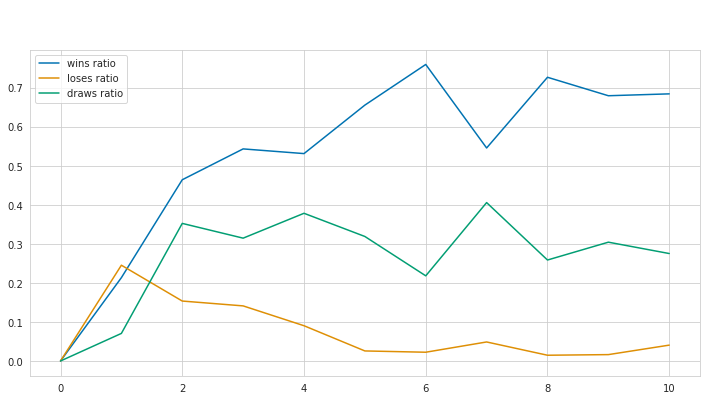

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(list(range(len(Q_wins))), Q_wins, label="wins ratio")
plt.plot(list(range(len(Q_loses))), Q_loses, label="loses ratio")
plt.plot(list(range(len(Q_draws))), Q_draws, label="draws ratio")
plt.suptitle("Win/loses/draws ratios by steps", color='white')
plt.legend()

# Dueling DQN

In [14]:
class DuelingNetworkDQN(nn.Module):
    def __init__(self, n_rows=3, n_cols=3):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 512, 3, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=n_rows + 2, stride=1)
        self.l1 = nn.Linear(512, 256)
        self.v = nn.Linear(256, 1)
        self.a = nn.Linear(256, n_rows * n_cols)
    def forward(self, x):
        x = self.to_multichannel(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x, 1)
        x = self.l1(x)
        x = F.relu(x)
        a = self.a(x)
        v = self.v(x)
        x = v + (a - a.mean(dim=1, keepdim=True))
        return x
    
    def to_multichannel(self, x):
        crosses_idx = torch.where(x == 1)
        naughts_idx = torch.where(x == -1)
        empty_spaces_idx = torch.where(x == 0)
        new_crosses = torch.zeros_like(x)
        new_naughts = torch.zeros_like(x)
        new_empty = torch.zeros_like(x)
        new_crosses[crosses_idx] = 1
        new_naughts[naughts_idx] = 1
        new_empty[empty_spaces_idx] = 1
        return torch.cat((new_crosses, new_naughts, new_empty), axis=1)

In [ ]:
N_ROWS, N_COLS, N_WIN = 4, 4, 4
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dqn = TicTacToeDQN(env, DuelingNetworkDQN, device)
Q_wins, Q_loses, Q_draws, Q_crashes = train_dqn(dqn, total_episodes=50000, episodes_estimation_interval=5000)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


Wins:0.0, Loses:0.0, Draws:0.0, Crashes:1.0
Wins:0.331, Loses:0.1888, Draws:0.1583, Crashes:0.3219
Wins:0.4739, Loses:0.1432, Draws:0.3358, Crashes:0.0471
Wins:0.5192, Loses:0.116, Draws:0.364, Crashes:0.0008
Wins:0.6062, Loses:0.0543, Draws:0.3395, Crashes:0.0
Wins:0.7077, Loses:0.0378, Draws:0.2545, Crashes:0.0
Wins:0.6179, Loses:0.0623, Draws:0.3198, Crashes:0.0
Wins:0.7684, Loses:0.0273, Draws:0.2043, Crashes:0.0
Wins:0.7396, Loses:0.0237, Draws:0.2367, Crashes:0.0
Wins:0.7263, Loses:0.0285, Draws:0.2452, Crashes:0.0

Wins:0.7164, Loses:0.0168, Draws:0.2668, Crashes:0.0


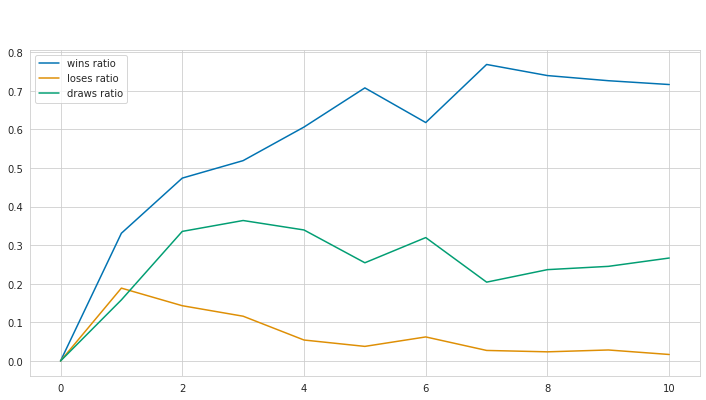

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(list(range(len(Q_wins))), Q_wins, label="wins ratio")
plt.plot(list(range(len(Q_loses))), Q_loses, label="loses ratio")
plt.plot(list(range(len(Q_draws))), Q_draws, label="draws ratio")
plt.suptitle("Win/loses/draws ratios by steps", color='white')
plt.legend()

# Rollouts / MCTS

## Rollouts with random strategy

In [15]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [16]:
import copy

In [41]:
def rollouts(env, action, pi=None, me=1, n_rollouts=10):
  rewards = []
  for _ in range(n_rollouts):
    env_copy = TicTacToe(env.n_rows, env.n_cols, env.n_win)
    env_copy.board = env.board.copy()
    env_copy.curTurn = env.curTurn
    observation, reward, done, info = env_copy.step(action)
    if done:
      rewards.append(reward)
      break
    s = observation[0]
    cur_turn = observation[-1]
    while not done:
      if cur_turn == me:
        if pi is not None:
          a = pi.getAction(s, eps=0)
        else:
          # a = np.random.randint(env_copy.n_rows * env_copy.n_cols)
          available_actions = [env_copy.int_from_action(x) for x in env_copy.getEmptySpaces()]
          a = np.random.choice(available_actions)
        observation, reward, done, info = env_copy.step(a)
        s_prime = observation[0]
        cur_turn_prime = observation[-1]
      else:
        available_actions = [env_copy.int_from_action(x) for x in env_copy.getEmptySpaces()]
        a = np.random.choice(available_actions)
        observation, reward, done, info = env_copy.step(a)
        s_prime = observation[0]
        cur_turn_prime = observation[-1]
      s, cur_turn = s_prime, cur_turn_prime
    if (reward == -1) and (me == -1):
      reward = -reward
    if (reward == -10) and (cur_turn != me):
      raise Exception("Opponent made wrong move")
    rewards.append(reward)
  return np.mean(rewards)

In [18]:
def calc_real_reward(cur_turn, me, reward):
  if (cur_turn == me) and (reward == -10):
    real_reward = -10
  if (cur_turn != me) and (reward == -10):
    raise Exception("Opponent made bad choose")
  if (reward != -10):
    real_reward = me * reward
  return real_reward

In [33]:
def test_strategy_with_rollouts(env, pi=None, me=None, n_rollouts=500):
  env.reset()
  s = env.getState()[0]
  if me:
    best_reward = -9999
    best_action = 0
    for i in range(env.n_rows * env.n_cols):
      cur_reward = rollouts(env, i, pi=pi, me=me, n_rollouts=n_rollouts)
      if cur_reward > best_reward:
        best_reward = cur_reward
        best_action = i
    a = best_action
  else:
    a = np.random.randint(env.n_rows * env.n_cols)
    
  while(1):
    observations, reward, done, _ = env.step(a)
    s = observations[0]
    cur_turn = observations[-1]
# Calculate real reward
    if done:
      real_reward = calc_real_reward(cur_turn, me, reward)
      return real_reward
# Choose action    
    if cur_turn == me:
      best_reward = -9999
      best_action = 0
      for i in range(env.n_rows * env.n_cols):
        cur_reward = rollouts(env, i, pi=pi, me=me, n_rollouts=n_rollouts)
        if cur_reward > best_reward:
          best_reward = cur_reward
          best_action = i
      a = best_action
    else:
      available_actions = [env.int_from_action(x) for x in env.getEmptySpaces()]
      a = np.random.choice(available_actions)

## 3x3

Try with random strategy

In [51]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
# Q1 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# Q2 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# pi1 = Policy(Q1, env.n_rows, env.n_cols)
# pi2 = Policy(Q2, env.n_rows, env.n_cols)
wins = 0
loses = 0
draws = 0
crashes = 0
for _ in tqdm_notebook(range(100)):
    me = np.random.choice([-1, 1])
    if me == 1:
      reward = test_strategy_with_rollouts(env, me=me)
    else:
      reward = test_strategy_with_rollouts(env, me=me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [54]:
Q_wins = wins / 100
Q_loses = loses / 100
Q_draws = draws / 100
Q_crashes = crashes / 100

In [55]:
print(f"Wins:{Q_wins}, Losses:{Q_loses}, Draws:{Q_draws}, Crashes:{Q_crashes}")

Wins:0.74, Losses:0.26, Draws:0.0, Crashes:0.0


Not bad but not good

Try with pretrained strategy

In [45]:
env = TicTacToe(n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN)
pi1, pi2, Q_wins, Q_loses, Q_draws, Q_crashes = train(env, 
                                     total_episodes=50000,
                                     total_episodes_test=10000,
                                     episodes_estimation_interval=30000,
                                     epsilon=0.3,
                                     alpha=0.01,
                                     gamma=1,)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Wins:0.0395, Loses:0.0722, Draws:0.0097, Crashes:0.8786
Wins:0.6205, Loses:0.2258, Draws:0.0232, Crashes:0.1305

Wins:0.7844, Loses:0.1568, Draws:0.0176, Crashes:0.0412


In [46]:
env = TicTacToe(N_ROWS, N_COLS, N_WIN)
wins = 0
loses = 0
draws = 0
crashes = 0
for _ in tqdm_notebook(range(100)):
    me = np.random.choice([-1, 1])
    if me == 1:
      reward = test_strategy_with_rollouts(env, pi1, me)
    else:
      reward = test_strategy_with_rollouts(env, pi2, me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [47]:
Q_wins = wins / 100
Q_loses = loses / 100
Q_draws = draws / 100
Q_crashes = crashes / 100

In [48]:
print(f"Wins:{Q_wins}, Losses:{Q_loses}, Draws:{Q_draws}, Crashes:{Q_crashes}")

Wins:0.88, Losses:0.11, Draws:0.01, Crashes:0.0


## 4x4

In [57]:
env = TicTacToe(4, 4, 4)
# Q1 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# Q2 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# pi1 = Policy(Q1, env.n_rows, env.n_cols)
# pi2 = Policy(Q2, env.n_rows, env.n_cols)
wins = 0
loses = 0
draws = 0
crashes = 0
for _ in tqdm_notebook(range(100)):
    me = np.random.choice([-1, 1])
    if me == 1:
      reward = test_strategy_with_rollouts(env, me=me)
    else:
      reward = test_strategy_with_rollouts(env, me=me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [60]:
Q_wins = wins / 100
Q_loses = loses / 100
Q_draws = draws / 100
Q_crashes = crashes / 100

In [61]:
print(f"Wins:{Q_wins}, Losses:{Q_loses}, Draws:{Q_draws}, Crashes:{Q_crashes}")

Wins:0.87, Losses:0.12, Draws:0.01, Crashes:0.0


## 5x5

In [63]:
env = TicTacToe(5, 5, 5)
# Q1 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# Q2 = defaultdict(lambda: np.random.random(env.n_rows * env.n_cols))
# pi1 = Policy(Q1, env.n_rows, env.n_cols)
# pi2 = Policy(Q2, env.n_rows, env.n_cols)
wins = 0
loses = 0
draws = 0
crashes = 0
for _ in tqdm_notebook(range(100)):
    me = np.random.choice([-1, 1])
    if me == 1:
      reward = test_strategy_with_rollouts(env, me=me)
    else:
      reward = test_strategy_with_rollouts(env, me=me)
    if reward == -1:
      loses += 1
    elif reward == 1:
      wins += 1
    elif reward == 0:
      draws += 1
    else:
      crashes += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [64]:
Q_wins = wins / 100
Q_loses = loses / 100
Q_draws = draws / 100
Q_crashes = crashes / 100

In [65]:
print(f"Wins:{Q_wins}, Losses:{Q_loses}, Draws:{Q_draws}, Crashes:{Q_crashes}")

Wins:0.95, Losses:0.05, Draws:0.0, Crashes:0.0


Роллауты прекрасно показали себя на разных размерах сетки.